In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

path = "/content/drive/MyDrive/CSV File/training.1600000.processed.noemoticon.csv"
df = pd.read_csv(path)

print("✅ Clean data loaded successfully!")
print(df.shape)
df

✅ Clean data loaded successfully!
(1596303, 2)


,target,clean_text
0,0,a thats a bummer you shoulda got david carr of...
1,0,is upset that he cant update his facebook by t...
2,0,i dived many times for the ball managed to sav...
3,0,my whole body feels itchy and like its on fire
4,0,no its not behaving at all im mad why am i her...
...,...,...
1596298,1,just woke up having no school is the best feel...
1596299,1,thewdbcom very cool to hear old walt interviews
1596300,1,are you ready for your mojo makeover ask me fo...
1596301,1,happy th birthday to my boo of alll time tupac...


In [3]:
!pip uninstall -y transformers accelerate
!pip install transformers==4.44.2 accelerate==0.34.2 --upgrade --quiet


Found existing installation: transformers 4.57.1
Uninstalling transformers-4.57.1:
  Successfully uninstalled transformers-4.57.1
Found existing installation: accelerate 1.11.0
Uninstalling accelerate-1.11.0:
  Successfully uninstalled accelerate-1.11.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 90.7 MB/s eta 0:00:00


In [4]:
!pip uninstall -y transformers accelerate tokenizers huggingface-hub


Found existing installation: transformers 4.44.2
Uninstalling transformers-4.44.2:
  Successfully uninstalled transformers-4.44.2
Found existing installation: accelerate 0.34.2
Uninstalling accelerate-0.34.2:
  Successfully uninstalled accelerate-0.34.2
Found existing installation: tokenizers 0.19.1
Uninstalling tokenizers-0.19.1:
  Successfully uninstalled tokenizers-0.19.1
Found existing installation: huggingface-hub 0.36.0
Uninstalling huggingface-hub-0.36.0:
  Successfully uninstalled huggingface-hub-0.36.0


In [5]:
!pip install transformers==4.44.2 accelerate==0.34.2 datasets==2.21.0 --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 33.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.6.1 which is incompatible.


In [6]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch, pandas as pd

print("✅ Transformers + Torch working fine!")


✅ Transformers + Torch working fine!


In [8]:
# --- Step 2: Load your data ---
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/MyDrive/CSV File/training.1600000.processed.noemoticon.csv"
df = pd.read_csv(path)

print("✅ Data loaded:", df.shape)
print(df.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Data loaded: (1596303, 2)
   target                                         clean_text
0       0  a thats a bummer you shoulda got david carr of...
1       0  is upset that he cant update his facebook by t...
2       0  i dived many times for the ball managed to sav...
3       0     my whole body feels itchy and like its on fire
4       0  no its not behaving at all im mad why am i her...


In [10]:
# --- Step 3: DistilBERT test training  ---

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
import pandas as pd

# Load data
path = "/content/drive/MyDrive/CSV File/training.1600000.processed.noemoticon.csv"
df = pd.read_csv(path)
print(" Data loaded:", df.shape)

# Use a small subset for quick test (1000 rows)
df_small = df.sample(n=1000, random_state=42)

# Split
X_train, X_test, y_train, y_test = train_test_split(df_small["clean_text"], df_small["target"], test_size=0.2, random_state=42)


# Convert to HF Dataset
train_dataset = Dataset.from_dict({'text': X_train.tolist(), 'label': y_train.tolist()})
test_dataset = Dataset.from_dict({'text': X_test.tolist(), 'label': y_test.tolist()})

# Model setup
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Tokenize
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# Light training settings
training_args = TrainingArguments(
    output_dir="./results_light",
    evaluation_strategy="epoch",
    save_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    num_train_epochs=1,
    weight_decay=0.01,
    push_to_hub=False,
    report_to="none",
    logging_steps=10
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
)

print("Starting training...")
trainer.train()
print(" Training complete")
print(" Evaluating model")
trainer.evaluate()


 Data loaded: (1596303, 2)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Starting training...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss
1,0.654300,0.639169


 Training complete
 Evaluating model


{'eval_loss': 0.639169454574585,
 'eval_runtime': 11.4479,
 'eval_samples_per_second': 17.47,
 'eval_steps_per_second': 2.184,
 'epoch': 1.0}

In [12]:
# Save model and tokenizer
trainer.save_model("sentiment_model_small")
tokenizer.save_pretrained("sentiment_model_small")

print("✅ Model and tokenizer saved in 'sentiment_model_small/'")


✅ Model and tokenizer saved in 'sentiment_model_small/'


In [19]:
import shutil

# Create a folder in your Drive to store models
drive_path = "/content/drive/MyDrive/twitter_sentiment_project/models/sentiment_model_small"

# Copy trained model from Colab temp storage → Drive
shutil.copytree("/content/sentiment_model_small", drive_path, dirs_exist_ok=True)

print("✅ Model saved to:", drive_path)


✅ Model saved to: /content/drive/MyDrive/twitter_sentiment_project/models/sentiment_model_small


In [14]:
from transformers import pipeline

# Load your trained model from Drive
model_path = "/content/drive/MyDrive/twitter_sentiment_project/models/sentiment_model_small"

# Create a sentiment-analysis pipeline
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model=model_path,
    tokenizer=model_path
)

# Try it on some examples
examples = [
    "I love this new update, it's amazing!",
    "This is the worst experience ever.",
    "It's okay, not too bad but not great either."
]

results = sentiment_analyzer(examples)

for text, res in zip(examples, results):
    print(f"📝 {text}\n➡️ {res}\n")


📝 I love this new update, it's amazing!
➡️ {'label': 'LABEL_1', 'score': 0.626964271068573}

📝 This is the worst experience ever.
➡️ {'label': 'LABEL_0', 'score': 0.5294633507728577}

📝 It's okay, not too bad but not great either.
➡️ {'label': 'LABEL_0', 'score': 0.5852550268173218}



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


✅ DistilBERT Evaluation Results:
Accuracy: 0.6800
Precision: 0.6807
Recall: 0.6800
F1 Score: 0.6779

Detected classes: [np.int64(0), np.int64(1)]

Detailed Report:
              precision    recall  f1-score   support

    Negative       0.68      0.75      0.71       105
    Positive       0.69      0.60      0.64        95

    accuracy                           0.68       200
   macro avg       0.68      0.68      0.68       200
weighted avg       0.68      0.68      0.68       200



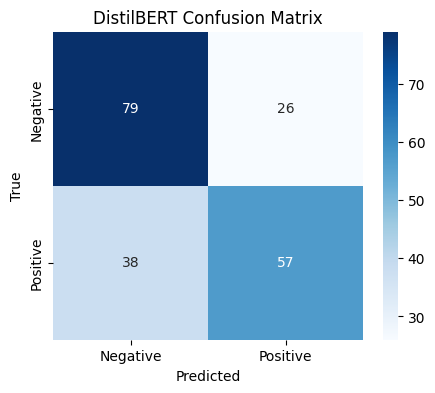

In [15]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Get predictions ----
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = np.array(test_dataset["label"])

# ---- Compute metrics ----
acc = accuracy_score(y_true, y_pred)
prec, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

print("✅ DistilBERT Evaluation Results:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# ---- Identify unique labels ----
unique_labels = sorted(np.unique(y_true))
print(f"\nDetected classes: {unique_labels}")

# ---- Classification report ----
label_names = ["Negative", "Positive"] if len(unique_labels) == 2 else ["Negative", "Neutral", "Positive"]
print("\nDetailed Report:")
print(classification_report(y_true, y_pred, target_names=label_names))

# ---- Confusion matrix ----
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("DistilBERT Confusion Matrix")
plt.show()


In [16]:
 from google.colab import drive
drive.mount('/content/drive')

save_path = "/content/drive/MyDrive/twitter_sentiment_project/models/distilbert_small_trained"

model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print(f"✅ Model and tokenizer saved to: {save_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model and tokenizer saved to: /content/drive/MyDrive/twitter_sentiment_project/models/distilbert_small_trained


In [20]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.68
